## <center> Advanced Statistical Methods. </center>
###  <center> Final Project by Nina Aleskerova. </center>

### Problem statement

Consider a regression model:

$$ Y_i = f^*(X_i) + \varepsilon_i,~~1 \leq i \leq n, $$

where 
- $f^∗$ is an unknown univariate function on $[0,1]$, 
- the design points equidistant, i.e. $X_i = \frac{i}{n} ~ \forall ~ 1 \leq i \leq n$, 
- $\varepsilon_i$  are independent zero-mean Gaussian random variables. 

We have to consider two situations:

1) the errors $\varepsilon_1, \dots, \varepsilon_n $ are identically distributed with respect to $N(0,\sigma^2)$ and $\sigma^2$ is known (**homogeneous noise**), 

2) $\varepsilon_i \sim N(0, \sigma_i^2)$ with unknown $\sigma_i^2$ but an averaged value $\sigma^2=\frac{1}{n}\sum\limits\sigma_i^2$ is given ( **inhomogeneous noise** ).

----------

The goal is to estimate a target functional with an adaptive method. Our functiinal will be (T2):

$$ L = (f^*)', $$
the performance is measured by

$$ \mathop{R}(\hat{f'}) = \mathop{\mathbb{E}}||\hat{f'} - (f^*)'||^2 = \sum_\limits{i = 1}^{n}\mathop{\mathbb{E}}\big(\hat{f'}(X_i) - (f^*)'(X_i)\big)^2 $$

We approximate the function $f^∗$ by **smoothing splines** (B4). 

We have to adaptively select the **penalty parameter** for smoothing splines with **leave-one-out cross-validation** (M2).

### Solution:

### 0. The number of observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.linalg as linalg
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

seed = 99

In [2]:
n = 200
x = np.linspace(0, 1, num = n)

### 1. Generate the function $f^*$ and find its derivative

We generate the our true function given Fourier basis:

$$
\Psi(x) = \{\psi_j(x)\}_{j=1}^{n}
$$

and randomly chosen coefficients $\{c_j\},\ j \in [1, n]$, with $\gamma_j$ i.i.d. standard normal

\begin{equation*}
c_j = 
 \begin{cases}
   \gamma_j,& j \in [1, 10] \\
   \frac{\gamma_j}{(j-10)^2}, & j \in [11, n] 
 \end{cases}, \\
 \gamma_j \sim N(0, 1)\ \forall j
\end{equation*}


$$ f^*(x) = c \cdot \Psi(x) = c_1 \psi_1(x) + \dots + c_{n} \psi_{n}(x), $$



In [3]:
class TrueFunction():
    def __init__(self, basis_size = n, seed = seed, x_ = x):
        np.random.seed(seed)
        self.basis_size = basis_size
        self.x = x_
        self.coefs = np.random.normal(0, 1, size = basis_size)
        self.coefs[10:] /= np.square(np.arange(1, n - 9)) ##np.square(np.arange(11, n + 1) - 10)
        #for i in range(10, basis_size):
        #    self.coefs[i] /= (i - 9)** 2
                
    def function(self):
        x = self.x
        basis = np.zeros((self.basis_size, x.shape[0]))
        indices = np.arange(0, self.basis_size // 2).reshape(-1, 1)
        basis[1::2, :] = np.sin(2 * np.pi * indices * x)
        basis[::2, :] = np.cos(2 * np.pi * indices * x) 
   
        res = basis.T @ self.coefs
        return res
        
    def target_functional(self):
        x = self.x
        basis = np.zeros((self.basis_size, x.shape[0]))
        indices = np.arange(0, self.basis_size // 2).reshape(-1, 1)
        basis[1::2, :] = 2 * np.pi * indices * np.cos(2 * np.pi * x * indices)
        basis[::2, :] = - 2 * np.pi * indices * np.sin(2 * np.pi * x * indices)    
    
        #        basis[i] = - 2 * np.pi * (i / 2) * np.sin(2 * np.pi * x * (i / 2))
        #        basis[i] = 2 * np.pi * (i // 2) * np.cos(2 * np.pi * x * (i // 2)) 
        
        res = basis.T @ self.coefs
        return res
    
    def plot_function_and_derivative(self):
        fontsize = 12
        f = self.function()
        df = self.target_functional()
    
        fig, axes = plt.subplots(2, 1, figsize=(11, 13))
        axes[0].plot(self.x, f, lw = 3)
        axes[0].grid(True)
        axes[0].set_title('True function $f^∗$', fontsize = fontsize)
        axes[0].set_xlabel('x', fontsize = fontsize)
        axes[0].set_ylabel('$f^∗(x)$', fontsize = fontsize)

        axes[1].plot(self.x, df, lw = 3)    
        axes[1].hlines(0, self.x.min(), self.x.max(), linestyle='dashed', color = 'red', lw = 2)
        axes[1].grid(True)
        axes[1].set_title('Target: the derivative of true function $f^∗$', fontsize = fontsize)
        axes[1].set_xlabel('x', fontsize = fontsize)
        axes[1].set_ylabel('$df^∗(x)/dx$', fontsize = fontsize)

        plt.show()

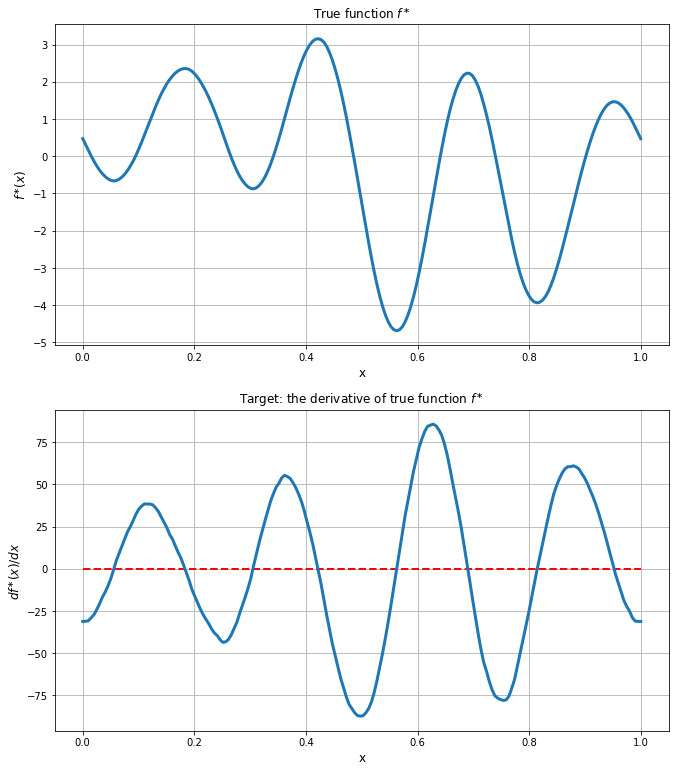

In [4]:
generator = TrueFunction()
true_F = generator.function()
true_dF = generator.target_functional()
generator.plot_function_and_derivative()

### 2. Generate the variances

In [5]:
class Variances():
    def __init__(self, f = true_F, n = n, seed = seed):
        self.n = n
        self.seed = seed
        self.f = f
        self.var_hom = self.generate_var(is_homogeneous = True)
        self.var_inhom = self.generate_var(is_homogeneous = False)
        self.generate_noise()
        self.generate_observations()
        
    def generate_var(self, is_homogeneous = None):
        np.random.seed(self.seed)
        if is_homogeneous:
            n = 1
        else:
            n = self.n
        var = np.random.multivariate_normal(mean = 2 * np.ones(n), cov = 0.4 * np.identity(n))
        var = np.square(var) * 0.8 ** 2
        var = np.sort(var)
        return var
    
    def get_var(self, is_homo = None):
        if is_homo:
            return self.var_hom
        else:
            return self.var_inhom
    
    def generate_noise(self):
        self.noise_hom = np.random.normal(loc = 0, scale = self.var_hom, size = self.n)
        self.noise_inhom = np.random.multivariate_normal(mean = np.zeros(n), cov = np.diag(self.var_inhom))
        
    def get_noise(self, is_homo = None):
        if is_homo:
            return self.noise_hom
        else:
            return self.noise_inhom
        
    def generate_observations(self):
        self.f_obs_hom = self.f + self.noise_hom
        self.f_obs_inhom = self.f + self.noise_inhom
        
    def get_observations(self, is_homo = None):
        if is_homo:
            return self.f_obs_hom
        else:
            return self.f_obs_inhom
        
    def plot_true_and_observations(self):
        fontsize = 12
        fig, axes = plt.subplots(2, 1, figsize=(12, 14), sharey=True)
        axes[0].plot(x, self.f, lw = 3, label = 'True', c = 'green')
        axes[0].scatter(x, self.f_obs_hom, marker = 'o', label = 'Observed', c = 'red', alpha = 0.7)
        axes[0].grid(True)
        axes[0].set_title('True and observed values (homogeneous noise)', fontsize = fontsize)
        axes[0].set_xlabel('x', fontsize = fontsize)
        axes[0].set_ylabel('y', fontsize = fontsize)
        axes[0].legend()
        
        axes[1].plot(x, self.f, lw = 3, label = 'True', c = 'green')
        axes[1].scatter(x, self.f_obs_inhom, marker = 'o', label='Observed', c = 'red', alpha = 0.7)
        axes[1].grid(True)
        axes[1].set_title('True and observed values (inhomogeneous noise)', fontsize = fontsize)
        axes[1].set_xlabel('x', fontsize = fontsize)
        axes[1].set_ylabel('y', fontsize = fontsize)
        axes[1].legend()

        plt.show()

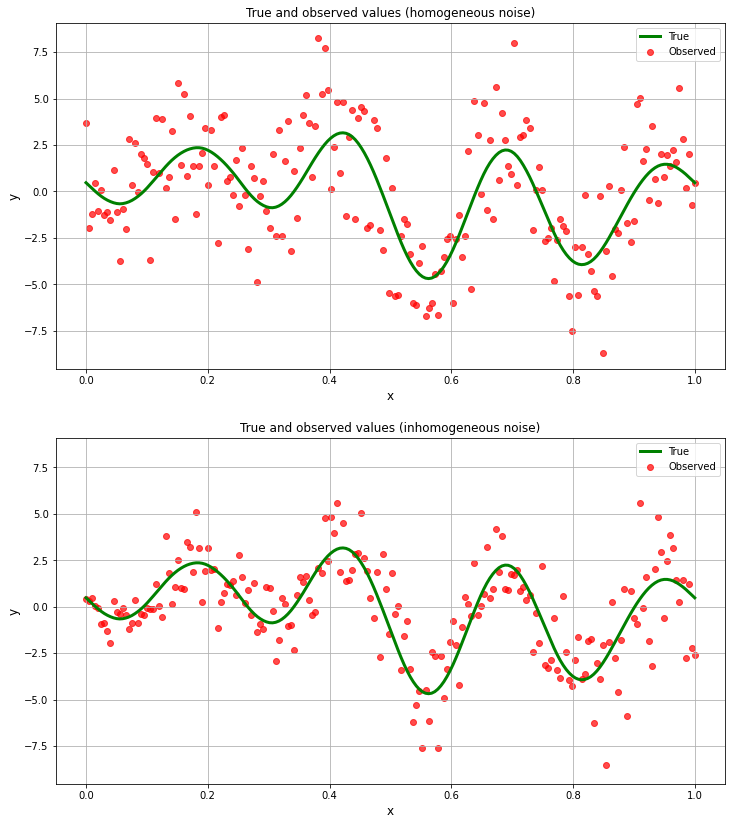

In [6]:
variance = Variances()
variance.plot_true_and_observations()

### 3. Specify the models

We fix a famly $M$ of parameters among which we will find the best one and $\forall m \in M$ compute the design matrix $\Psi_m$.

In case of smoothing splines, we optimize the penalized log-likelihood:
$$
L_{\lambda}(f) \stackrel{def}{=} L(f) - \lambda R_q(f) = - \frac{1}{2 \sigma^2}\sum\limits_{i = 1}^{n}|Y_i - f(X_i)|^2 - \lambda \int_{X}{|f^{(q)}(x)|^2 dx},
$$

where $X = \{X_i\}_{i = 1}^{n}$ - a space of features.


The corresponding maximizer is the penalized maximum likelihood estimator (we consider cubic smoothing splines, $q = 3$):
$$
\tilde{f_{\lambda}} = \underset{f}{\text{argmax}} L_{\lambda}(f) = \underset{f}{\text{argmin}} \bigl( \sum\limits_{i = 1}^{n}|Y_i - f(X_i)|^2 + \lambda \int_{X}{|f^{''}(x)|^2 dx} \bigr)
$$

From lemma 1.8.2 from the book we know that the parameter dimension of the spline space is $n + q = n + 3$. 

One possible basis in this space is given by polynomials $x^{m}$ of degree $m = 0, 1, ...q$ and the functions $\phi_k(x) = (x - x_k)_{+}^{q}, ~k = 1,...n$:

$$
\begin{equation*}
\psi_j(x) = 
 \begin{cases}
   x^j, ~~0 \leq j \leq 3\\
   (x-x_{j-3})_{+}^3, ~~4 \leq j \leq n + 2
 \end{cases}
\end{equation*}
$$ 


Each model in our case is characterized by a smoothing (penalty) parameter $\lambda$.

In [7]:
M = np.concatenate((np.logspace(-5, -1.2, 10), np.linspace(0.1, 1, 10)))
print(f'Family of parameters:{M}')

Family of parameters:[1.00000000e-05 2.64376119e-05 6.98947321e-05 1.84784980e-04
 4.88527357e-04 1.29154967e-03 3.41454887e-03 9.02725178e-03
 2.38658979e-02 6.30957344e-02 1.00000000e-01 2.00000000e-01
 3.00000000e-01 4.00000000e-01 5.00000000e-01 6.00000000e-01
 7.00000000e-01 8.00000000e-01 9.00000000e-01 1.00000000e+00]


### 4. Oracle choice and oracle risk

So, our basis matrix $\Psi(x)$ has shape $ (n + 3) \times n $:

$$ \Psi(x) = (\psi_0(x), \dots , \psi_{n+2}(x))^{\top} $$

Our goal is to find $\theta = (\theta_0, \dots, \theta_{n+2})^{\top}$ such that

$$ f(x) = \sum_{j=0}^{n+2} \theta_j \psi_j(x) = \Psi(x)^{\top} \theta $$

Then the second derivative can be expressed as:

$$ 
f''(x) = \Psi(x)''^{\top} \theta = \sum_\limits{j=0}^{n+2} \theta_j \psi_j''(x) 
$$

$$
(f''(x))^2 = \sum_{i, j=0}^{n+2} \theta_i \theta_j \psi_i''(x) \cdot \psi_j''(x) = \theta^{\top} A(x) \theta,
$$

$$A(x) = \{\psi_i''(x) \cdot \psi_j''(x)\}_{i, j = 0}^{n + 2}$$

And the penalty term:

$$
\lambda \int_{X}{(f''(x))^2 dx} = \lambda \int_{X} \theta^{\top} A(x) \theta dx = \lambda \theta^{\top} \int_{X} A(x) dx \cdot \theta = \lambda  \theta^{\top} \tilde{I} \theta,$$

where

$$ \tilde{I}_{ij} = \underset{X} \int \psi_i''(x) \psi_j''(x) dx = \int_{0}^{1} \psi_i''(x) \psi_j''(x) dx $$

We can rewrite our optimization problem 
$$
\sum\limits_{i = 1}^{n}|Y_i - f(X_i)|^2 + \lambda \int_{X}{|f^{''}(x)|^2 dx} \rightarrow \underset{f}{\text{min}} 
$$

in the form:

$$ ||Y - \Psi^{\top} \theta ||^2 + \lambda \theta^{\top} \tilde{I}\theta \rightarrow \underset{\theta} \min $$

And the optimal solution (MLE) is

$$ \tilde{\theta}_{\lambda} = (\Psi \Psi^{\top} + \lambda \tilde{I})^{-1} \Psi Y = S_{\lambda} Y$$

The estimates of the original function and its derivative - target functional - can be computed as

$$
\tilde{f}_{\lambda} = \Psi^{\top} \tilde{\theta}_{\lambda} = \Psi^{\top} S_{\lambda} Y
$$
$$
\tilde{f'}_{\lambda} = (\Psi')^{\top} \tilde{\theta}_{\lambda} = (\Psi')^{\top} S_{\lambda} Y = K_{\lambda} Y 
$$


For each model $m \in M$ (characterized by $\lambda$) we compute the MLE ($\tilde{\theta}_{\lambda}$) and its true risk $R_m$.

In [8]:
class SmoothingSplines():
    def __init__(self, y, knots = x, lambd = 0.01, m = 3): 
        self.knots = knots
        self.m = m
        self.x_min, self.x_max = knots[0], knots[-1]
        self.n = knots.shape[0]
        self.basis_size = self.n + self.m
        self.y = y
        
        self.basis = self.get_psi()
        self.penalty = lambd * self.get_integral()
        self.get_S_and_theta()
        
        
    def get_psi(self, x = None):
        if x is None:
            x = self.knots
        basis = np.zeros((self.basis_size, x.shape[0]))
        for i in range(self.m + 1):
            basis[i, :] = x**i      
        for i in range(self.m + 1, self.basis_size):
            j = i - (self.m + 1)
            basis[i, :] = np.maximum(np.zeros(x.shape[0]), (x - self.knots[j])**self.m)
        return basis
    
        
    
    def get_basis_dif(self, x = None):
        if x is None:
            x = self.knots
        basis_d = np.zeros((self.basis_size, x.shape[0]))
        for i in range(1, self.m + 1):
            basis_d[i, :] = i * x**(i - 1)
        for i in range(self.m + 1, self.basis_size):
            j = i - (self.m + 1)
            basis_d[i, :] = self.m * np.maximum(np.zeros(x.shape[0]), (x - self.knots[j]))**(self.m - 1)          
        return basis_d
    
    
    #def get_basis_2dif(self):
    #    basis_2d = []
    #    for i in range(self.basis_size):
    #        if i < self.m - 1:
    #            basis_2d.append(lambda x: 0)
    #        elif i == self.m - 1:
    #            basis_2d.append(lambda x: 2)
    #        elif i == self.m:
    #            basis_2d.append(lambda x: self.m * (self.m - 1) * x)
    #        else:
    #            j = i - (self.m + 1)
    #            basis_2d.append(lambda x: self.m * (self.m - 1) * (x - self.knots[j]))#**(self.m - 2))
    #    return basis_2d      
    
    def get_splines(self, x0):
        basis_ = self.get_psi(x0)
        return basis_.T @ self.theta
    
    def get_target_functional(self, x0):
        basis_dif = self.get_basis_dif(x0)
        return basis_dif.T @ self.theta
    
    def get_K(self, x0):
        basis_dif = self.get_basis_dif(x0)
        return basis_dif.T @ self.S
    

    def d2_function(self, x0):
        return lambda x: 6 * (x - x0) 
    
    def get_integral(self):
        basis_d2 = [lambda x: 0, lambda x: 0, lambda x: 2, lambda x: self.m * (self.m - 1) * x]
        basis_d2.extend([self.d2_function(self.knots[i]) for i in range(0, self.n - 1)])
        #basis_d2.extend([lambda x: 6 * (x - knots[i]) for i in range(0, self.n - 1)])
        
        integral = np.zeros((self.basis_size, self.basis_size))
        
        for i in range(integral.shape[0]):
            for j in range(integral.shape[0]):
                if i > self.m or j > self.m:  
                    low_lim = self.knots[max(i, j) - self.m - 1]
                    integral[i, j] = integrate.quad(lambda x: basis_d2[i](x) * basis_d2[j](x), 
                                                      low_lim, self.x_max)[0]
                else:
                    integral[i, j] = integrate.quad(lambda x: basis_d2[i](x) * basis_d2[j](x),
                                                      self.x_min, self.x_max)[0]
        return integral    
    
        
        
    def get_S_and_theta(self):
        self.S = linalg.pinv(self.basis @ self.basis.T + self.penalty) @ self.basis
        self.theta = self.S @ self.y

**Target loss**:

$$ Loss = ||\tilde{f_m'} - (f^*)'||^2_n = \frac{1}{n} \sum_{i=1}^n (\tilde{f_m'}(X_i) - (f^*)'(X_i))^2 $$

**Risk**:



$$ R_m = \mathbb{E}[Loss] = \frac{1}{n} [Loss + tr(K_m Cov(\varepsilon) K_m^{\top})] =  \frac{1}{n}[||\tilde{f_m'} - (f^*)'||^2 + tr(K_m Cov(\varepsilon) K_m^{\top})]  $$

In [9]:
class Oracle():
    def __init__(self, knots = x, x = x, M = M):
        self.M = M
        self.x = x
        self.knots = knots
        self.losses = np.zeros(len(M))
        self.risks = np.zeros(len(M))
        self.estimate_F = []
        self.estimate_dF = []
        
    def __call__(self, obs_F, cov, true_F = true_F, true_dF = true_dF):
        for k in range(len(M)):
            spline = SmoothingSplines(knots = self.knots, y = obs_F, lambd = M[k])
            est_F = spline.get_splines(self.x)
            est_dF = spline.get_target_functional(self.x)
            self.estimate_F.append(est_F)
            self.estimate_dF.append(est_dF)
            
            K = spline.get_K(x)
            loss_ = self.get_loss(true_dF, est_dF)
            R_ = self.get_R(true_dF, est_dF, K, cov)
            self.losses[k] = loss_
            self.risks[k] = R_

            l_orig = self.get_loss(true_F, est_F)

            print(f'Smoothing parameter = {round(self.M[k], 6)}, for functional: loss = {round(loss_, 3)}, risk = {round(R_, 3)}')
            print(f'for the true function: loss = {round(l_orig, 3)}')    
    
        oracle_opt = np.argmin(self.risks)
        oracle_param = self.M[oracle_opt]
        oracle_risk = self.risks[oracle_opt]
        oracle_f = self.estimate_F[oracle_opt]
        oracle_df = self.estimate_dF[oracle_opt]
        return self.risks, oracle_param, oracle_risk, oracle_f, oracle_df

    
    
    def get_loss(self, true, pred):
        return np.linalg.norm(true - pred)**2 / pred.shape[0]

    
    def get_R(self, target_true, target_pred, K, cov):
        deterministic = self.get_loss(target_true, target_pred)
        stochastic  = np.trace(K @ cov @ K.T) / target_true.shape[0]    
        return deterministic + stochastic


    
    def plot_R(self):
        x_ = np.arange(len(self.M))
        fontsize = 12
        plt.figure(figsize = (10, 5))
        plt.plot(x_, self.risks, marker = 'x', markersize = 3)
        plt.xticks(x_, self.M, rotation = 'vertical')
        plt.grid()
        plt.xlabel('Smoothing parameter lambda', fontsize = fontsize)
        plt.ylabel('Risk', fontsize = fontsize )
        plt.title('Risk dependance on penalty (smoothing) parameter', fontsize = fontsize)
        plt.show()

    def plot_oracle(self, f_est, df_est, x = x, f_true = true_F, df_true = true_dF):
        fontsize = 12
        fig, axes = plt.subplots(2, 1, figsize=(11, 11))
        axes[0].plot(x, f_true, lw = 3, label = 'True')
        axes[0].plot(x, f_est, lw = 3, label = 'Estimate', c = 'red')
        axes[0].grid(True)
        axes[0].set_title('True function and oracle estimation', fontsize = fontsize)
        axes[0].set_xlabel('x', fontsize = fontsize)
        axes[0].set_ylabel('f', fontsize = fontsize)
        axes[0].legend()

        axes[1].plot(x, df_true, lw = 3, label = 'True')
        axes[1].plot(x, df_est, lw = 3, label = 'Estimate', c = 'red')
        axes[1].grid(True) 
        axes[1].set_title('True function derivative and oracle estimation', fontsize = fontsize)
        axes[1].set_xlabel('x', fontsize = fontsize)
        axes[1].set_ylabel('$df/dx$', fontsize = fontsize)   
        axes[1].legend()
    
        plt.show()

#### Homogeneous noise

In [10]:
variances = Variances()
var_hom = variances.get_var(is_homo = True)
cov_hom = var_hom * np.identity(n)
f_obs_hom = variances.get_observations(is_homo = True)

oracle = Oracle(x)
risk_homo, oracle_homo_param, oracle_risk_homo, f_oracle_homo, df_oracle_homo = oracle(f_obs_hom, cov_hom)
print(f'Best param is {round(oracle_homo_param, 5)} with risk {round(oracle_risk_homo, 3)}')

Smoothing parameter = 1e-05, for functional: loss = 548.733, risk = 895.822
for the true function: loss = 0.496
Smoothing parameter = 2.6e-05, for functional: loss = 284.602, risk = 457.593
for the true function: loss = 0.421
Smoothing parameter = 7e-05, for functional: loss = 197.64, risk = 284.283
for the true function: loss = 0.368
Smoothing parameter = 0.000185, for functional: loss = 260.463, risk = 304.215
for the true function: loss = 0.41
Smoothing parameter = 0.000489, for functional: loss = 546.525, risk = 568.832
for the true function: loss = 0.731
Smoothing parameter = 0.001292, for functional: loss = 1012.2, risk = 1023.701
for the true function: loss = 1.413
Smoothing parameter = 0.003415, for functional: loss = 1459.281, risk = 1465.284
for the true function: loss = 2.22
Smoothing parameter = 0.009027, for functional: loss = 1758.118, risk = 1761.294
for the true function: loss = 2.838
Smoothing parameter = 0.023866, for functional: loss = 1910.82, risk = 1912.524
for th

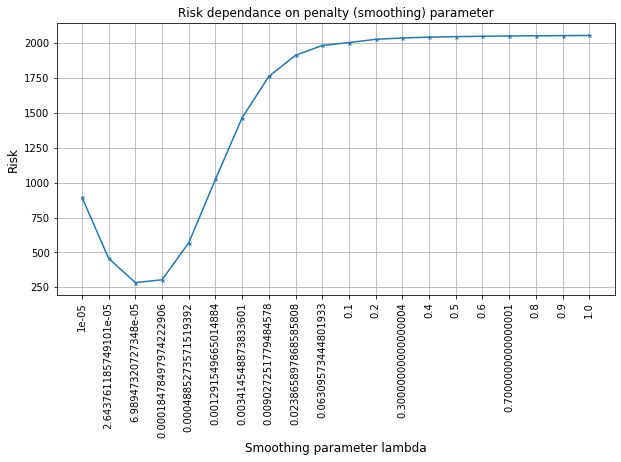

In [11]:
oracle.plot_R()

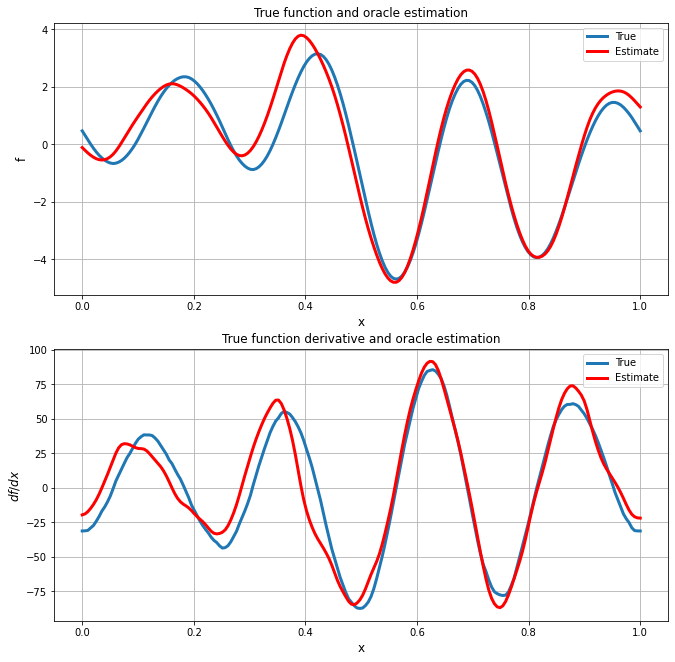

In [12]:
oracle.plot_oracle(f_oracle_homo, df_oracle_homo)

#### Inhomogeneous noise

In [13]:
var_inhom = variances.get_var(is_homo = False)
cov_inhom = np.diag(var_inhom)
f_obs_inhom = variances.get_observations(is_homo = False)

oracle = Oracle(x)
risk_inhomo, oracle_inhomo_param, oracle_risk_inhomo, f_oracle_inhomo, df_oracle_inhomo = oracle(f_obs_inhom, cov_inhom)
print(f'Best param is {round(oracle_inhomo_param, 5)} with risk {round(oracle_risk_inhomo, 3)}')

Smoothing parameter = 1e-05, for functional: loss = 579.296, risk = 1026.165
for the true function: loss = 0.25
Smoothing parameter = 2.6e-05, for functional: loss = 299.774, risk = 524.361
for the true function: loss = 0.184
Smoothing parameter = 7e-05, for functional: loss = 147.864, risk = 261.316
for the true function: loss = 0.168
Smoothing parameter = 0.000185, for functional: loss = 201.373, risk = 259.104
for the true function: loss = 0.322
Smoothing parameter = 0.000489, for functional: loss = 542.291, risk = 571.901
for the true function: loss = 0.823
Smoothing parameter = 0.001292, for functional: loss = 1067.236, risk = 1082.566
for the true function: loss = 1.639
Smoothing parameter = 0.003415, for functional: loss = 1524.156, risk = 1532.182
for the true function: loss = 2.444
Smoothing parameter = 0.009027, for functional: loss = 1800.828, risk = 1805.086
for the true function: loss = 2.996
Smoothing parameter = 0.023866, for functional: loss = 1935.208, risk = 1937.495


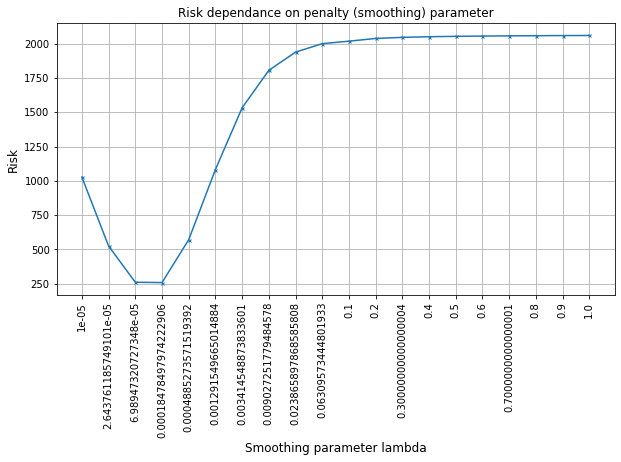

In [14]:
oracle.plot_R()

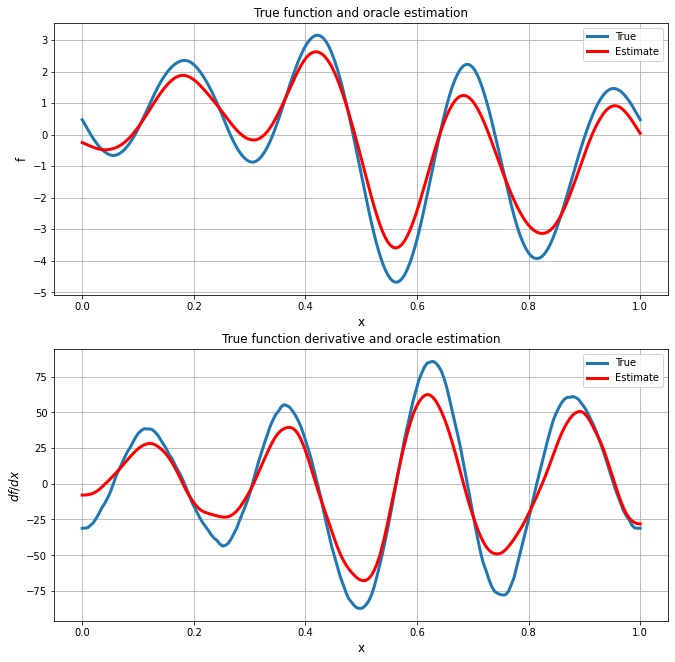

In [15]:
oracle.plot_oracle(f_oracle_inhomo, df_oracle_inhomo)

### 5. Adaptive choice of the parameter

We use leave-one-out cross-validation.

In [30]:
def cross_validation_risk(y_obs, lambd, X = x, y = true_F):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    risks = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_obs_train, y_obs_test = y_obs[train_index], y_obs[test_index]
        #cov_cut = np.delete(cov, test_index, axis = 0)
        #cov_cut = np.delete(cov_cut, test_index, axis = 1)
        
        spline = SmoothingSplines(knots = X_train, y = y_obs_train, lambd = lambd)
        est_F = spline.get_splines(X_test)
        #est_dF = spline.get_target_functional(X_test)
        #K = spline.get_K(X_test)
        
        R_ = np.linalg.norm(y_test - est_F)**2 / y_test.shape[0]
        #(np.linalg.norm(y_test - est_dF)**2 + 
             #           np.trace(K @ cov_cut @ K.T)) / y_test.shape[0] 
        risks.append(R_)
    return sum(risks) / len(risks) #np.mean(risks) #
     
       

def model_selection(y_obs, X = x, y = true_F):
    risks_ = []
    for lamb in tqdm(M):
        risks_.append(cross_validation_risk(y_obs, lamb, X = X, y = y))
        print(risks_[-1])
    opt_idx = np.argmin(risks_)
    lambda_cv = M[opt_idx]
    risk_cv = risks_[opt_idx]
    print(f'Optimal smoothing parameter = {round(lambda_cv, 6)}')
    print(f'Optimal risk = {round(risk_cv, 3)}')
    
    
    spline = SmoothingSplines(knots = X, y = y_obs, lambd = lambda_cv)
    f_cv = spline.get_splines(X)
    df_cv = spline.get_target_functional(X)
    
    return lambda_cv, risk_cv, f_cv, df_cv

In [31]:
def plot_result_cv(f_est, df_est, x = x, f_true = true_F, df_true = true_dF, f_oracle = None, df_oracle = None):
    fontsize = 12
    fig, axes = plt.subplots(2, 1, figsize=(11, 11))
    axes[0].plot(x, f_true, lw = 3, label = 'True')
    axes[0].plot(x, f_est, lw = 3, label = 'Estimate', c = 'red')
    if (f_oracle is not None):
        axes[0].plot(x, f_oracle, lw = 3, label = 'Oracle estimation of function', c = 'green')
    axes[0].grid(True)
    axes[0].set_title('True function and oracle estimation', fontsize = fontsize)
    axes[0].set_xlabel('x', fontsize = fontsize)
    axes[0].set_ylabel('f', fontsize = fontsize)
    axes[0].legend()

    axes[1].plot(x, df_true, lw = 3, label = 'True')
    axes[1].plot(x, df_est, lw = 3, label = 'Estimate', c = 'red')
    if (df_oracle is not None):
        axes[1].plot(x, df_oracle, lw = 3, label = 'Oracle estimation of derivative', c = 'green')
    axes[1].grid(True) 
    axes[1].set_title('True function derivative and oracle estimation', fontsize = fontsize)
    axes[1].set_xlabel('x', fontsize = fontsize)
    axes[1].set_ylabel('$df/dx$', fontsize = fontsize)   
    axes[1].legend()
    
    plt.show()

In [ ]:
lambda_hom_cv, risk_hom_cv, f_hom_cv, df_hom_cv = model_selection(f_obs_hom)

  5%|▌         | 1/20 [17:48<5:38:12, 1068.01s/it]

0.5655314482154019


 10%|█         | 2/20 [33:02<4:53:18, 977.70s/it] 

0.47058624106327235


 15%|█▌        | 3/20 [48:17<4:28:52, 949.00s/it]

0.4099913186055963


 20%|██        | 4/20 [1:04:50<4:17:44, 966.55s/it]

0.46314464289547586


 25%|██▌       | 5/20 [2:13:33<8:46:07, 2104.53s/it]

0.8207575597563248


 30%|███       | 6/20 [2:17:31<5:42:59, 1469.94s/it]

1.5453945878843773


 35%|███▌      | 7/20 [2:21:29<3:51:16, 1067.43s/it]

2.376213676710672


In [ ]:
plot_result_cv(f_hom_cv, df_hom_cv, f_oracle = f_oracle_homo, df_oracle = df_oracle_homo)

In [18]:
lambda_hom_cv, risk_hom_cv, f_hom_cv, df_hom_cv = model_selection(f_obs_hom, cov_hom)

  5%|▌         | 1/20 [04:33<1:26:39, 273.67s/it]

912.5138100635809


 10%|█         | 2/20 [08:53<1:19:35, 265.31s/it]

472.2612311959056


 15%|█▌        | 3/20 [12:52<1:11:50, 253.58s/it]

298.1875068222317


 20%|██        | 4/20 [16:53<1:06:17, 248.59s/it]

317.9954737913878


 25%|██▌       | 5/20 [20:54<1:01:26, 245.74s/it]

580.8488918995271


 30%|███       | 6/20 [25:02<57:30, 246.47s/it]  

1030.4482497826602


 35%|███▌      | 7/20 [29:29<54:54, 253.40s/it]

1467.2439710283818


 40%|████      | 8/20 [33:37<50:16, 251.40s/it]

1760.9851659809751


 45%|████▌     | 9/20 [37:40<45:36, 248.80s/it]

1911.409646292261


 50%|█████     | 10/20 [41:41<41:06, 246.63s/it]

1981.7952933097552


 55%|█████▌    | 11/20 [45:42<36:44, 244.90s/it]

2002.7324766162608


 60%|██████    | 12/20 [49:42<32:25, 243.21s/it]

2026.1841352830575


 65%|██████▌   | 13/20 [53:41<28:14, 242.14s/it]

2036.2660292801336


 70%|███████   | 14/20 [57:40<24:06, 241.07s/it]

2042.0157459159618


 75%|███████▌  | 15/20 [1:01:59<20:32, 246.59s/it]

2045.7662677799003


 80%|████████  | 16/20 [1:06:21<16:44, 251.23s/it]

2048.41927314698


 85%|████████▌ | 17/20 [1:10:42<12:42, 254.08s/it]

2050.4013067739616


 90%|█████████ | 18/20 [1:15:02<08:31, 255.74s/it]

2051.9416123358437


 95%|█████████▌| 19/20 [1:19:18<04:15, 255.84s/it]

2053.174896102442


100%|██████████| 20/20 [1:23:22<00:00, 250.13s/it]

2054.1857105025574
Optimal smoothing parameter = 7e-05
Optimal risk = 298.188


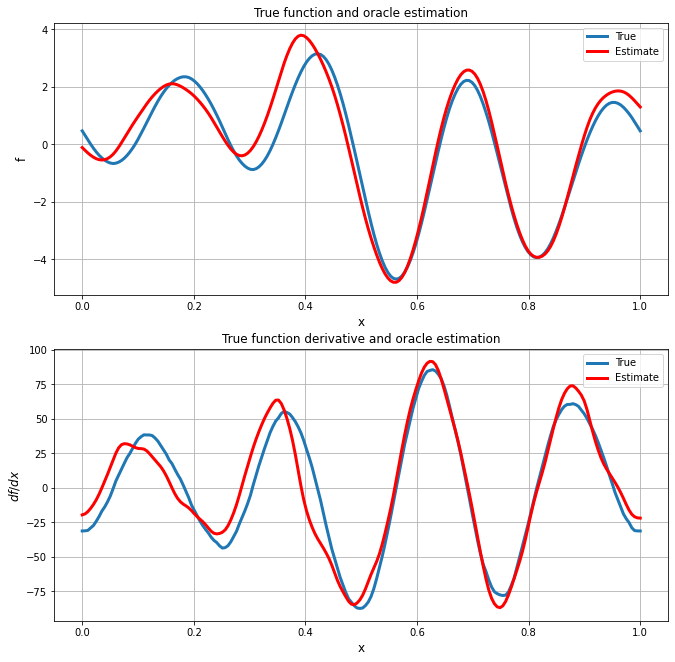

In [19]:
plot_result_cv(f_hom_cv, df_hom_cv)

### 6. Inhomogeneous noise

In [20]:
lambda_inhom_cv, risk_inhom_cv, f_inhom_cv, df_inhom_cv = model_selection(f_obs_inhom, cov_inhom)

  5%|▌         | 1/20 [04:35<1:27:13, 275.46s/it]

1007.0957801252414


 10%|█         | 2/20 [09:03<1:21:22, 271.23s/it]

511.147416848224


 15%|█▌        | 3/20 [13:41<1:17:39, 274.07s/it]

257.3410771170744


 20%|██        | 4/20 [18:27<1:14:25, 279.08s/it]

264.69809220750346


 25%|██▌       | 5/20 [22:40<1:07:23, 269.55s/it]

582.2637431862872


 30%|███       | 6/20 [26:45<1:00:56, 261.15s/it]

1090.9267551008058


 35%|███▌      | 7/20 [30:51<55:31, 256.31s/it]  

1536.5095904658056


 40%|████      | 8/20 [34:55<50:27, 252.26s/it]

1806.7764007596397


 45%|████▌     | 9/20 [38:59<45:47, 249.75s/it]

1937.8332910878482


 50%|█████     | 10/20 [43:19<42:07, 252.77s/it]

1998.985048646412


 55%|█████▌    | 11/20 [48:13<39:49, 265.53s/it]

2017.0256161708123


 60%|██████    | 12/20 [52:44<35:36, 267.09s/it]

2036.7067600515054


 65%|██████▌   | 13/20 [57:05<30:56, 265.25s/it]

2044.8845074101523


 70%|███████   | 14/20 [1:01:08<25:50, 258.49s/it]

2049.437064973384


 75%|███████▌  | 15/20 [1:05:10<21:08, 253.62s/it]

2052.3503827081777


 80%|████████  | 16/20 [1:09:11<16:39, 249.96s/it]

2054.378657353284


 85%|████████▌ | 17/20 [1:13:13<12:21, 247.33s/it]

2055.8735911080134


 90%|█████████ | 18/20 [1:17:14<08:11, 245.56s/it]

2057.021869809133


 95%|█████████▌| 19/20 [1:21:32<04:09, 249.17s/it]

2057.9319733379148


100%|██████████| 20/20 [1:25:54<00:00, 257.70s/it]

2058.671258451634
Optimal smoothing parameter = 7e-05
Optimal risk = 257.341


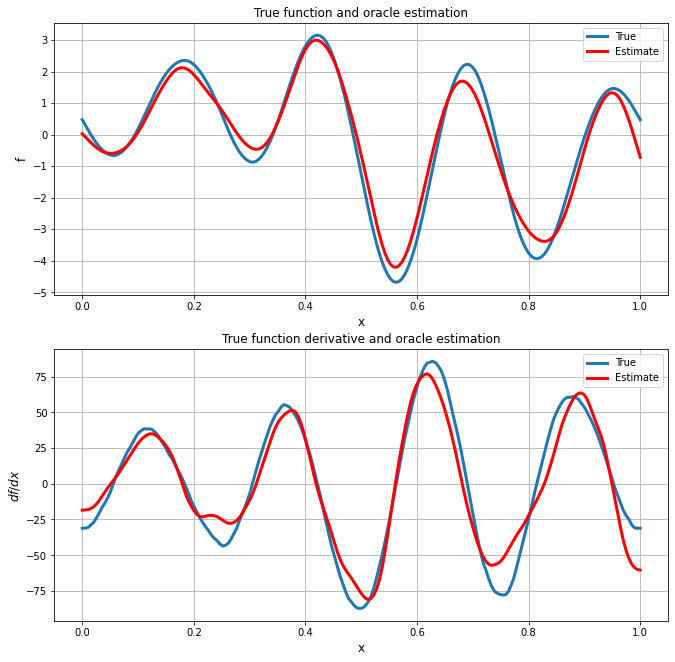

In [21]:
plot_result_cv(f_inhom_cv, df_inhom_cv)

In [ ]:
lambda_inhom_cv, risk_inhom_cv, f_inhom_cv, df_inhom_cv = model_selection(f_obs_inhom)

In [ ]:
plot_result_cv(f_inhom_cv, df_inhom_cv, f_oracle = f_oracle_inhomo, df_oracle = df_oracle_inhomo)